In [0]:
!pip install cupy

     |████████████████████████████████| 3.1MB 4.8MB/s 
  Created wheel for cupy: filename=cupy-6.3.0-cp36-cp36m-linux_x86_64.whl size=26507104 sha256=2856676cb758c13da705635fc519c515ee0438e2f34bff6a8983092a2966d94d
  Stored in directory: /root/.cache/pip/wheels/49/05/7a/f968e2923d52197be7f850e3d83b3976e2e8ea957e6a2f81f8
Successfully built cupy


In [0]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time

In [0]:
# Define a 2D domain for assessing heat equation and parameters
nx = 512
ny = 512

#Cell sizes
dx = 2.0*np.pi/float(nx)
dy = 2.0*np.pi/float(ny)

#Indices
index_range = cp.arange(0,nx+2)
x, y = cp.meshgrid(dx*index_range-dx,dy*index_range-dy)
#Initialize on device
u = cp.array(cp.sin(x+y))
#Initialize on host
ucpu = cp.asnumpy(cp.sin(x+y))

#diffusion parameter
alpha = 0.8
#Stable timestep
dt = 0.8*dx*dx/(4.0*alpha)
const_mult = alpha*dt/(dx*dx)

#length of solution
ft = 1.0
nt = int(ft/dt)

In [0]:
# Function to plot the field
def plot_field_gpu(x,y,u,title):
    ucpu = cp.asnumpy(u) # in case arrays are in device
    xcpu = cp.asnumpy(x)
    ycpu = cp.asnumpy(y)
    #levels = np.linspace(-1, 1, 20)
    fig, ax = plt.subplots(nrows=1,ncols=1)
    ax.set_title(title)
    p1 = ax.contourf(xcpu,ycpu,ucpu)
    plt.colorbar(p1,ax=ax)#,format="%.2f"
    plt.show()

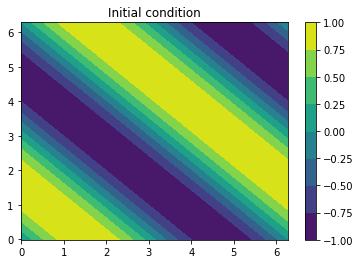

In [122]:
# Plotting the initial condition
plot_field(x,y,u,'Initial condition')

In [0]:
# Function for looping FTCS - cpu
def vectorized_ftcs_cpu(u):
  
    utemp = np.copy(u)
    t = 0
    while t<nt:
        t = t+1
        utemp[:,:] = u[:,:]
        u[1:nx+1,1:ny+1] = utemp[1:nx+1,1:ny+1] + const_mult*(-4.0*utemp[1:nx+1,1:ny+1]+(utemp[0:nx,1:ny+1]+
                            utemp[2:nx+2,1:ny+1]+utemp[1:nx+1,0:ny]+utemp[1:nx+1,2:ny+2]))

        #Update BCS
        #Need to update BCs - x direction
        u[0:1,1:ny+1] = u[nx:nx+1,1:ny+1]
        u[nx+1:nx+2,1:ny+1] = u[1:2,1:ny+1]

        #Need to update BCs - y direction
        u[0:nx+2,0:1] = u[0:nx+2,ny:ny+1]
        u[0:nx+2,ny+1:ny+2] = u[0:nx+2,1:2]

    del(utemp)
    return u

In [0]:
# Function for looping FTCS - gpu
def vectorized_ftcs_gpu(u):

    utemp = cp.copy(u,order='C')

    t = 0
    while t<nt:
        t = t+1
        utemp[:,:] = u[:,:]

        u[1:nx+1,1:ny+1] = utemp[1:nx+1,1:ny+1] + const_mult*(-4.0*utemp[1:nx+1,1:ny+1]+(utemp[0:nx,1:ny+1]+
                            utemp[2:nx+2,1:ny+1]+utemp[1:nx+1,0:ny]+utemp[1:nx+1,2:ny+2]))

        #Update BCS
        #Need to update BCs - x direction
        u[0:1,1:ny+1] = u[nx:nx+1,1:ny+1]
        u[nx+1:nx+2,1:ny+1] = u[1:2,1:ny+1]

        #Need to update BCs - y direction
        u[0:nx+2,0:1] = u[0:nx+2,ny:ny+1]
        u[0:nx+2,ny+1:ny+2] = u[0:nx+2,1:2]
 
    del(utemp)
    return u

CPU time taken for vectorized FTCS:  61.932042837142944


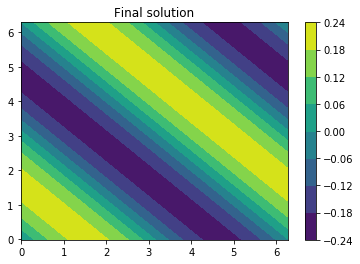

In [125]:
t1 = time.time()
ucpu = vectorized_ftcs_cpu(ucpu)
print('CPU time taken for vectorized FTCS: ',time.time()-t1)
plot_field(x,y,ucpu,'Final solution')

GPU time taken for vectorized FTCS:  5.743999481201172


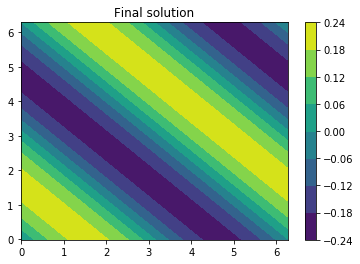

In [126]:
t1 = time.time()
u = vectorized_ftcs_gpu(u)
print('GPU time taken for vectorized FTCS: ',time.time()-t1)
plot_field(x,y,u,'Final solution')